# <span style="color:black;">NDVI time series</span>

***Developed by Lucas Ferreira***

In [1]:
# Importing libraries
import rasterio
import xarray
import rioxarray
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# If you don't have these libraries, you can install them using conda
# conda install -c conda-forge rasterio
# conda install -c conda-forge xarray
# conda install -c conda-forge rioxarray
# conda install -c conda-forge pandas
# conda install matplotlib

ModuleNotFoundError: No module named 'xarray'

## <span style="color:black;"> NDVI time series</span>

- The dataset is composed of 4 Sentinel-2 images.
- Each image is a subset a full Sentinel-2 tile.
- Each image has 4 bands: Blue, Green, Red, and NIR.
- The date of each image is encoded in the filename.

In [80]:
# Open the dataset
folder = 'dataset/'
# Let's list all the tif files in the folder
geotiff_files = list(Path(folder).glob('*.tif'))
geotiff_files

[WindowsPath('dataset/sample_s2_2022-02-14.tif'),
 WindowsPath('dataset/sample_s2_2022-03-26.tif'),
 WindowsPath('dataset/sample_s2_2022-06-04.tif'),
 WindowsPath('dataset/sample_s2_2022-06-24.tif')]

In [81]:
# Extracting dates embedded in the filenames
dates = [f.name.split('_')[2].split('.')[0] for f in geotiff_files]
# Converting the dates to datetime objects
dates = [pd.to_datetime(d) for d in dates]
dates

[Timestamp('2022-02-14 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-06-04 00:00:00'),
 Timestamp('2022-06-24 00:00:00')]

## <span style="color:black;">Handling files using rasterio</span>


### <span style="color:black;">Exploring the dataset</span>


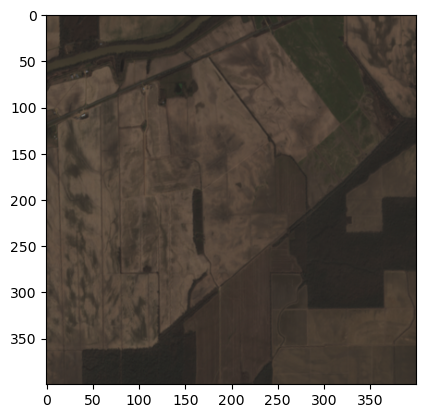

In [52]:
# Open the first file
with rasterio.open(geotiff_files[0]) as src:
    # The parameter masked=True, tells rasterio to return a masked array,
    # where the possible invalid values are masked.
    first_image = src.read(masked=True)

# Lets plot the RGB bands using matplotlib
# Select the RGB bands
rgb_idx = [2, 1, 0]
rgb_image = first_image[rgb_idx, :, :]
# We need to transpose the array to get the correct shape,
# as matplotlib expects the channels to be the last dimension
# and rasterio returns the channels as the first dimension.
rgb_image = rgb_image.transpose(1, 2, 0)
plt.imshow(rgb_image)
plt.show()

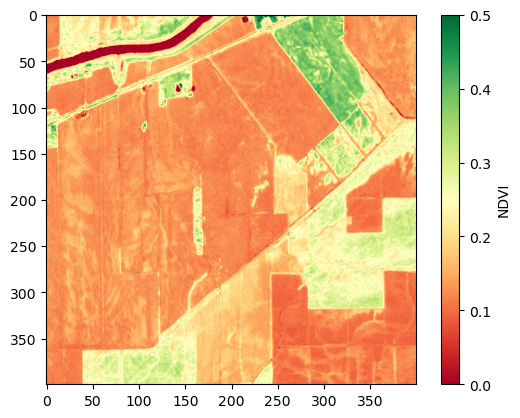

In [55]:
# Compute and plot NDVI
def compute_ndvi(image):
    red_idx = [2]
    nir_idx = [3]
    red_band = image[red_idx, :, :]
    nir_band = image[nir_idx, :, :]
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi

ndvi = compute_ndvi(first_image)
ndvi = ndvi.transpose(1, 2, 0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=0.5)
plt.colorbar(label='NDVI')
plt.show()

### <span style="color:black;">Computing and plotting NDVI across time</span>


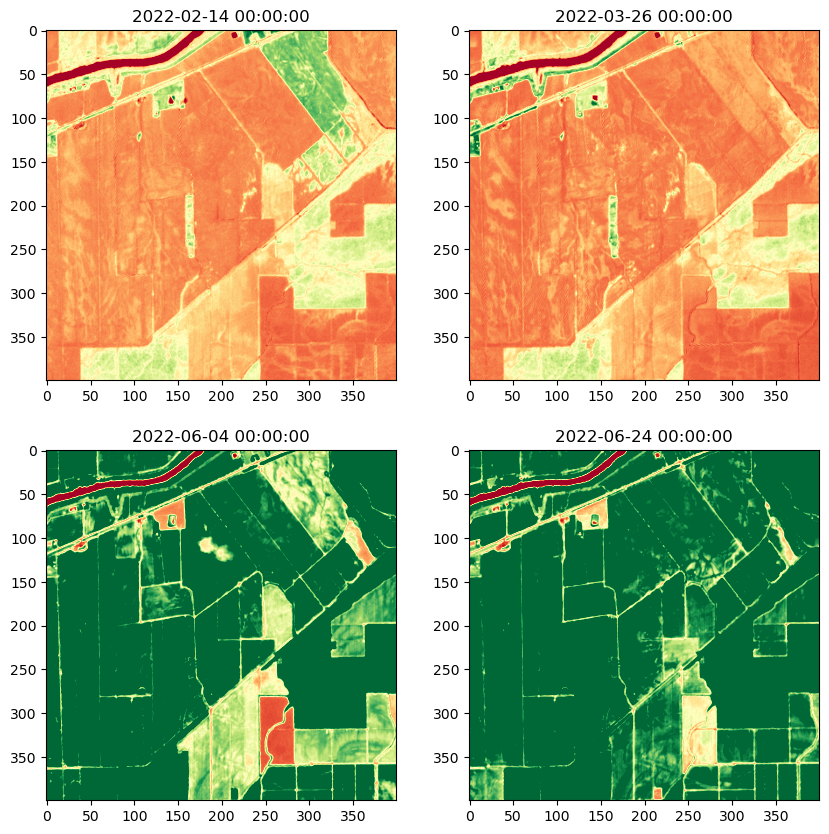

In [73]:
# Read all the images in the folder
images = []
for file in geotiff_files:
    with rasterio.open(file) as src:
        images.append(src.read(masked=True))

# Compute the NDVI for all the images
ndvi_images = []
for image in images:
    ndvi = compute_ndvi(image)
    ndvi_images.append(ndvi)

# Plot all NDVI images
fig = plt.figure(figsize=(10, 10))
for i, ndvi in enumerate(ndvi_images):
    ax = fig.add_subplot(2, 2, i+1)
    ndvi = ndvi.transpose(1, 2, 0)
    date = dates[i]
    ax.set_title(date)
    ax.imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=0.5)
plt.show()

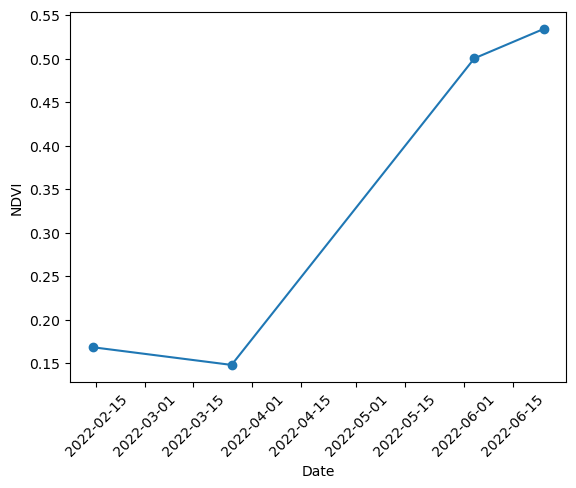

In [96]:
# Now let's create n NDVI time series. For this we will compute the mean NDVI for each image/date.
mean_ndvi_values = []
for image in ndvi_images:
    mean_ndvi = image.mean()
    mean_ndvi_values.append(mean_ndvi)

# Plot the time series
plt.plot(dates, mean_ndvi_values, 'o-')
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

## <span style="color:black;">Handling files using Xarray</span>

- Xarray is a Python package that makes it easy to work with multi-dimensional data.
- We can do the same things we did with rasterio, but with fewer lines of code.

In [83]:
# Load images into an xarray DataArray
# To read tiff files we need to use rioxaarray,
# a library that extends xarray to work with raster data.
# Open all files
xr_images = []
for file, date in zip(geotiff_files, dates):
    image = rioxarray.open_rasterio(file, masked=True)
    # Add date information
    image['date'] = date
    xr_images.append(image)

# Concatenate all images into a single xarray DataArray along the date dimension
data_array = xarray.concat(xr_images, dim='date')
data_array

<xarray.DataArray (date: 4, band: 4, y: 400, x: 400)>
array([[[[0.2396, 0.2426, 0.2442, ..., 0.2564, 0.2528, 0.2328],
         [0.2398, 0.2406, 0.248 , ..., 0.2528, 0.2452, 0.232 ],
         [0.2366, 0.2424, 0.2464, ..., 0.2494, 0.2462, 0.2346],
         ...,
         [0.2096, 0.1997, 0.2034, ..., 0.1769, 0.1752, 0.1751],
         [0.21  , 0.1984, 0.2036, ..., 0.1761, 0.1754, 0.1753],
         [0.208 , 0.2024, 0.2016, ..., 0.175 , 0.1752, 0.1754]],

        [[0.2954, 0.2914, 0.2982, ..., 0.3038, 0.2956, 0.2752],
         [0.292 , 0.2922, 0.299 , ..., 0.3038, 0.286 , 0.2754],
         [0.287 , 0.297 , 0.2996, ..., 0.2992, 0.2932, 0.2748],
         ...,
         [0.252 , 0.2382, 0.2412, ..., 0.205 , 0.2028, 0.201 ],
         [0.2514, 0.2336, 0.2408, ..., 0.2084, 0.2066, 0.2024],
         [0.2484, 0.2396, 0.2382, ..., 0.2054, 0.2036, 0.2028]],

        [[0.3566, 0.3552, 0.3584, ..., 0.3686, 0.3554, 0.3354],
         [0.352 , 0.3532, 0.361 , ..., 0.3656, 0.35  , 0.3232],
         [0.3486, 0.3552, 0.358 , ..., 0.3612, 0.3544, 0.3188],
         ...,
...
         [0.2238, 0.1759, 0.1778, ..., 0.1584, 0.1604, 0.1601],
         [0.2182, 0.1768, 0.1782, ..., 0.1598, 0.1604, 0.1604],
         [0.2084, 0.177 , 0.1796, ..., 0.1588, 0.1612, 0.1614]],

        [[0.1383, 0.1408, 0.1436, ..., 0.139 , 0.1371, 0.1512],
         [0.1557, 0.1522, 0.1534, ..., 0.1377, 0.1367, 0.1476],
         [0.1512, 0.1525, 0.1554, ..., 0.1378, 0.1359, 0.1437],
         ...,
         [0.2354, 0.1676, 0.1618, ..., 0.1409, 0.1408, 0.1407],
         [0.239 , 0.162 , 0.1628, ..., 0.1408, 0.1404, 0.1403],
         [0.2258, 0.162 , 0.1677, ..., 0.1418, 0.1411, 0.1408]],

        [[0.5433, 0.552 , 0.5551, ..., 0.5345, 0.5307, 0.5256],
         [0.5355, 0.537 , 0.537 , ..., 0.5355, 0.5408, 0.5307],
         [0.5528, 0.5468, 0.5416, ..., 0.5363, 0.5419, 0.5343],
         ...,
         [0.4749, 0.4864, 0.4849, ..., 0.492 , 0.4988, 0.5016],
         [0.4793, 0.4909, 0.4885, ..., 0.4937, 0.5025, 0.5064],
         [0.4805, 0.4981, 0.4865, ..., 0.4905, 0.4991, 0.5023]]]],
      dtype=float32)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 6.03e+05 6.03e+05 6.03e+05 ... 6.07e+05 6.07e+05
  * y            (y) float64 3.497e+06 3.497e+06 ... 3.493e+06 3.493e+06
    spatial_ref  int32 0
  * date         (date) datetime64[ns] 2022-02-14 2022-03-26 ... 2022-06-24
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

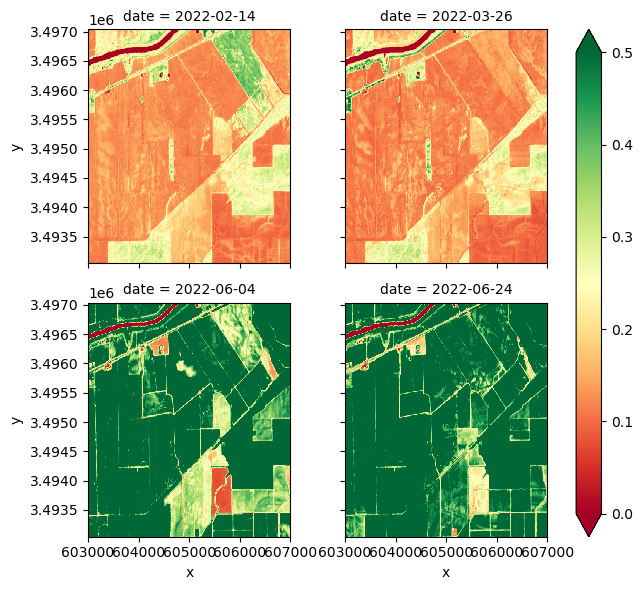

In [93]:
# Compute NDVI
red_band = data_array.sel(band=3)
nir_band = data_array.sel(band=4)
ndvi = (nir_band - red_band) / (nir_band + red_band)
# Xarray has nice plotting capabilities, making it easy to plot the NDVI time series in a single line of code.
ndvi.plot.imshow(col='date', cmap='RdYlGn', vmin=0, vmax=0.5, col_wrap=2)

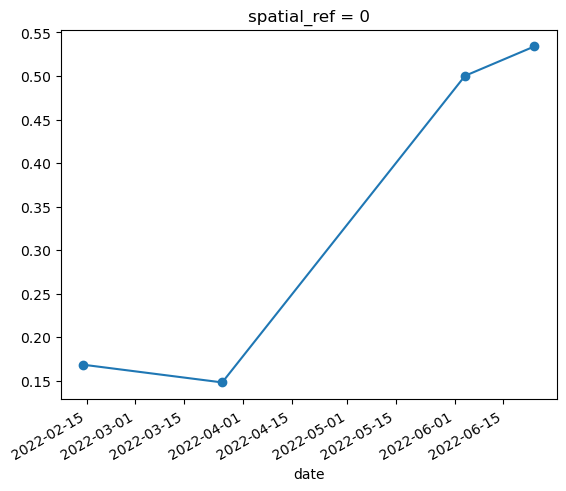

In [94]:
# Plotting NDVI time series
mean_ndvi = ndvi.mean(dim=['x', 'y'])
mean_ndvi.plot.line('o-')

# Conclusion
- Both rasterio and xarray are great libraries for working with raster data.
- When handling multitemporal data, xarray is probably a better choice.